In [ ]:
# Initialize Everything
import math
import numpy as np
import pandas as pd
from numpy import genfromtxt
import cv2
from google.colab.patches import cv2_imshow
import copy
from scipy.ndimage.filters import uniform_filter1d


In [ ]:
# Import data file as numpy array
! wget -O img1.jpg "https://drive.google.com/uc?export=download&id=1m_qcw9wiY6pTRrOzTWBH8LxMMgatMaFD"
data = genfromtxt('https://drive.google.com/uc?export=download&id=1JnHcWVpF6toejQGam0QktU3ehsCKCOqt', delimiter=',')

--2020-12-12 23:13:02--  https://drive.google.com/uc?export=download&id=1m_qcw9wiY6pTRrOzTWBH8LxMMgatMaFD
Resolving drive.google.com (drive.google.com)... 74.125.142.100, 74.125.142.139, 74.125.142.101, ...
Connecting to drive.google.com (drive.google.com)|74.125.142.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-3s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hihs9k0im3gk30gob45thc326j2mje4p/1607814750000/12673633878481174778/*/1m_qcw9wiY6pTRrOzTWBH8LxMMgatMaFD?e=download [following]
--2020-12-12 23:13:03--  https://doc-0o-3s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hihs9k0im3gk30gob45thc326j2mje4p/1607814750000/12673633878481174778/*/1m_qcw9wiY6pTRrOzTWBH8LxMMgatMaFD?e=download
Resolving doc-0o-3s-docs.googleusercontent.com (doc-0o-3s-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to doc-0o-3s-docs.googleusercontent.com (doc-0o

In [ ]:
row, col = data.shape

new_pixel_y = np.zeros((row,1))
new_pixel_x = np.zeros((row,1))
x_orig = np.zeros((row,1))

# Columns are as follows: [0]'frame', [1]'trackID', [2]'pixel_x', [3]'pixel_y', [4]'boxwidth', [5]'boxheight'

for r in range(row):
    new_pixel_y[r] = data[r, 3] + data[r,5] # Move the pixel_y from the top of the box to the bottom
    new_pixel_x[r] = data[r, 2] + data[r,4]/2 # Move the pixel_x from the left of the box to the center
    x_orig[r] = data[r,2]
    
all_data = np.hstack((data, new_pixel_x, new_pixel_y))

xy_coords = np.hstack((new_pixel_x, new_pixel_y))



In [ ]:
# Specific homography transform for MOT17-03-FRCNN.txt

T = np.array([[1.66085552, 1.26628137, 294.421528],
 [0.0518318303, 6.77169859, 631.124594],
 [0.0000172772768, 0.000927897617, 1.00000000]])
print('T:', T)

T: [[1.66085552e+00 1.26628137e+00 2.94421528e+02]
 [5.18318303e-02 6.77169859e+00 6.31124594e+02]
 [1.72772768e-05 9.27897617e-04 1.00000000e+00]]


In [ ]:
# Transform xy_coords using homography transform

x_t = np.zeros((row,1))
y_t = np.zeros((row,1))

rows,cols=all_data.shape
a = np.zeros((3,1))

for r in range(row):
    a = [[xy_coords[r,0]],
        [xy_coords[r,1]],
        [1.0]]
    
    X = np.matmul(T,a)

    c = X[2]

    x_t[r] = X[0]/c
    y_t[r] = X[1]/c
    
xy_coord_t = np.hstack((x_t,y_t))

In [ ]:
# trying a moving average filter on the transformed x and y points to smooth out extra distance measured caused by bounding box jitteryness
x_width = 15
y_width = 15
x_w = np.ones(x_width)/x_width
y_w = np.ones(y_width)/y_width

a = np.transpose(np.vstack((all_data[:,1], xy_coord_t[:,0], xy_coord_t[:,1])))

track_list = np.split(a, np.cumsum(np.unique(a[:, 0], return_counts=True)[1])[:-1])

filt_track_list = []
for track in track_list:
  filt_track_list.append(uniform_filter1d(track, size=x_width, axis=0))


In [ ]:
track_diff_list = []

for track in filt_track_list:
  length = track.shape[0] - 1
  diff = np.zeros((length,2))
  for i in range(length):
    diff[i,0] = track[i+1,1] - track[i,1]
    diff[i,1] = track[i+1,2] - track[i,2]

  track_diff_list.append(diff)


In [ ]:
dist_unscaled_list = []
for diff in track_diff_list:
  # print('diff:', diff)
  dist = 0
  for i in range(diff.shape[0]):
    dist += np.sqrt(diff[i,0]**2 + diff[i,1]**2)

  dist_unscaled_list.append(dist)

print('dist_unscaled_list[0:9]:', dist_unscaled_list[0:9])

dist_unscaled_list[0:9]: [110.27012578094123, 308.221576076515, 2111.225962946537, 1859.7737989309678, 2521.003519852638, 1455.5944007016549, 461.2451262130274, 320.43587658865823, 1409.4089559824483]


In [ ]:
#scale to meters

#rear_tire = np.array([1970, 2697])
#front_tire = np.array([1978, 2971])
#wheelbase_pixels = np.linalg.norm(rear_tire - front_tire)
#print('wheelbase pixels:', wheelbase_pixels)
#wheelbase_meters = 2.72 #estimate based of 2005 Camry
#scale_factor = wheelbase_meters/wheelbase_pixels
scale_factor = 0.5588/80 #based on a 22-inch (0.5588 m) manhole cover that has an 80 pixel diameter
print("scale_factor:", scale_factor)

dist_scaled_m_list = []
dist_scaled_ft_list = []
for dist in dist_unscaled_list:
  dist_scaled_m_list.append(dist*scale_factor)
  dist_scaled_ft_list.append(dist*scale_factor*3.281)

trackIDs_of_interest = np.array([1,2,3,4,6,8, 10, 21, 31])

print('dist_scaled_m_list:', dist_scaled_m_list[0:9])
print('dist_scaled_ft_list:', dist_scaled_ft_list[0:9])

scale_factor: 0.006985
dist_scaled_m_list: [0.7702368285798745, 2.1529277088944574, 14.746913351181561, 12.99051998553281, 17.609209586170675, 10.167326888901059, 3.221797206597996, 2.2382445979717778, 9.844721557537401]
dist_scaled_ft_list: [2.5271470345705684, 7.063755812882715, 48.384622705226704, 42.621896072533154, 57.775816652225984, 33.358999522484375, 10.570716634848026, 7.343680525945403, 32.300531430280216]


In [ ]:
img1 = cv2.imread('img1.jpg')
flatImg = cv2.warpPerspective(img1,T,(5000,5000))
#cv2_imshow(flatImg)


In [ ]:
origin = np.array([0,0,1])
origin_til = np.matmul(T, origin)
origin_prime = [origin_til[0]/origin_til[2], origin_til[1]/origin_til[2]]

og_shape = img1.shape
bl = np.array([0, og_shape[0], 1])
tr = np.array([og_shape[1], 0, 1])
bl_til = np.matmul(T, bl)
tr_til = np.matmul(T, tr)
bl_prime = [bl_til[0]/bl_til[2], bl_til[1]/bl_til[2]]
tr_prime = [tr_til[0]/tr_til[2], tr_til[1]/tr_til[2]]


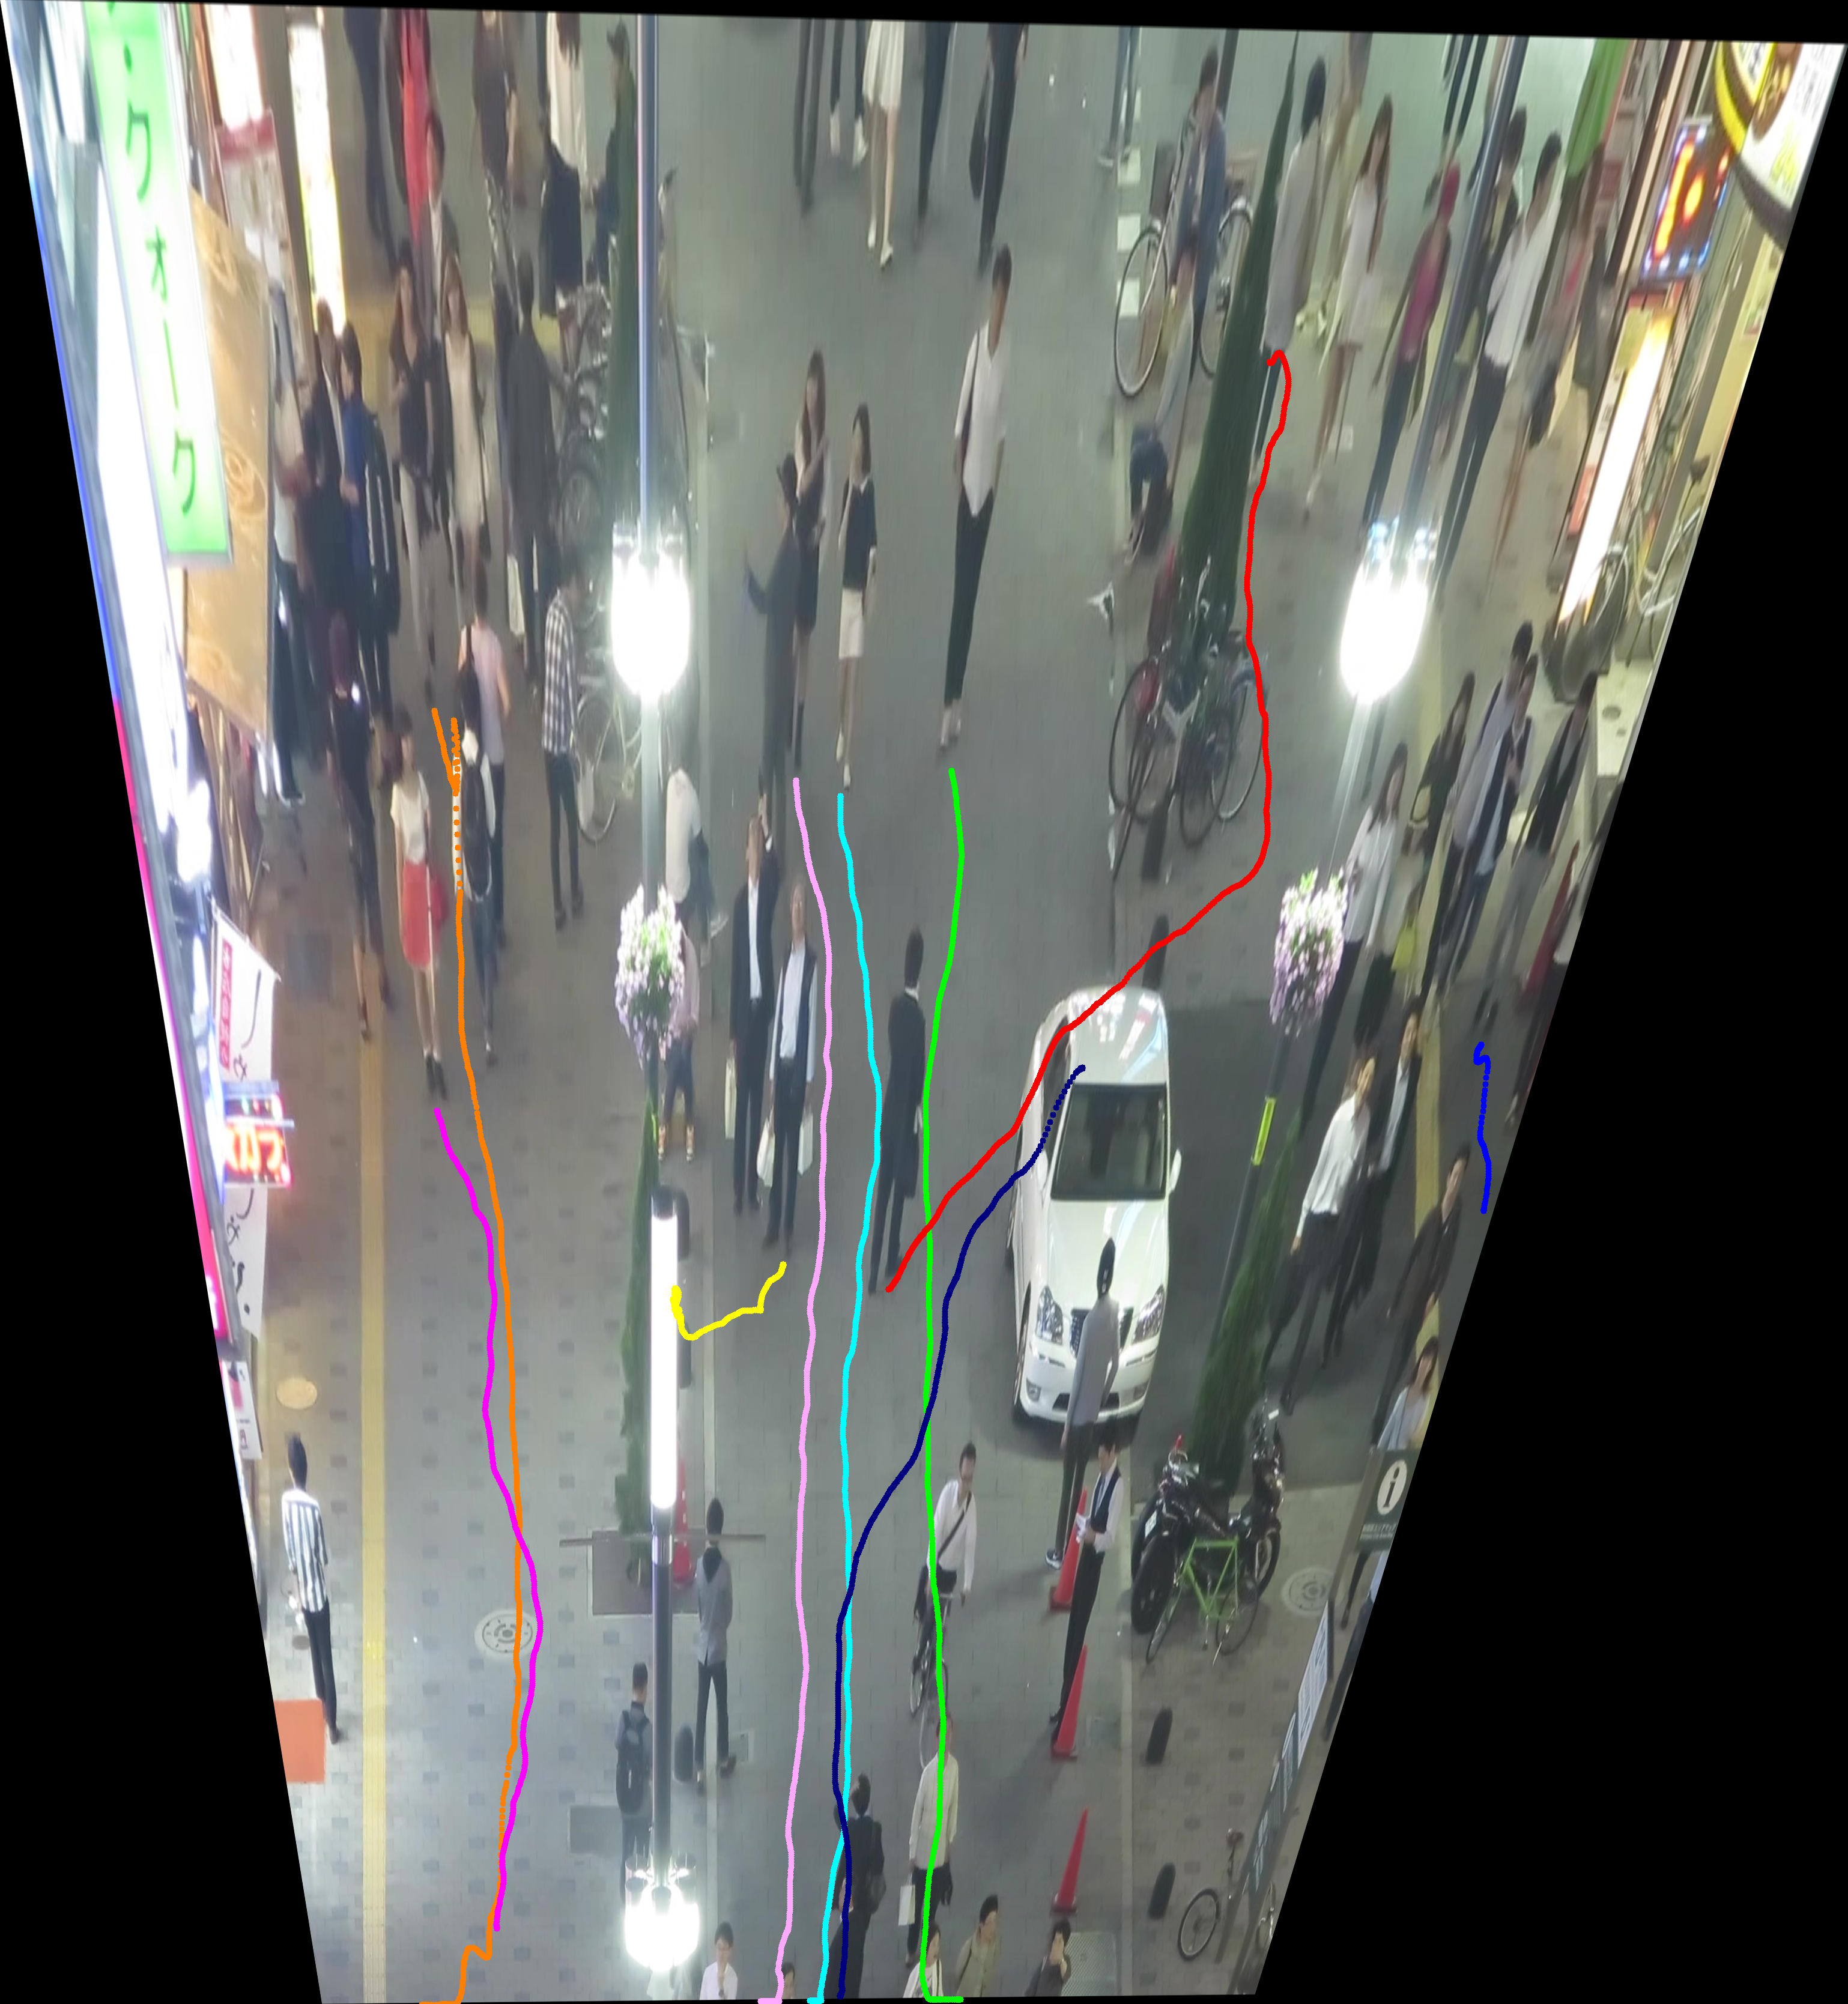

In [ ]:
flat_crop = copy.deepcopy(flatImg)
flat_crop = flat_crop[int(origin_prime[1]):int(bl_prime[1]),int(origin_prime[0]):int(tr_prime[0]),:]

tracks_to_draw = (1,2,3,4,6,8, 10, 21, 31)
colors = ((255, 0, 0), (0,255,0), (0, 0, 255), (0, 127, 255), (0, 255, 255), (255, 0, 255), (255, 255, 0), (255, 170, 255), (127, 0, 0), (0, 0, 127))
bbox_sizes = ((200, 700), (200, 850), (200, 700), (200, 700), (200, 700), (200, 750), (200, 700), (200, 700), (200, 650), (200, 700), (200, 700)) 

for j in range(len(tracks_to_draw)):
  trackID = tracks_to_draw[j]
  track = filt_track_list[trackID]
  shift = np.tile(origin_prime, (track.shape[0],1))
  track_shifted = track[:,1:] - shift
  size = bbox_sizes[j]
  bl = (int(track_shifted[0, 0] - size[0]/2), int(track_shifted[0, 1]))
  tr = (int(track_shifted[0, 0] + size[0]/2), int(track_shifted[0, 1] - size[1]))
  # cv2.rectangle(flat_crop, bl, tr, colors[j], thickness=3)
  for i in range(track_shifted.shape[0]):
    coords = (int(track_shifted[i,0]), int(track_shifted[i,1]))
    cv2.circle(flat_crop, coords, 5, colors[j], -1)
    


cv2_imshow(flat_crop)
# print('x-range:', int(origin_prime[0]), ':', int(tr_prime[0]))
# print('y-range:', int(origin_prime[1]), ':', int(bl_prime[1]))
